solution of 1D heat conduction and convection equation 

Marcin Moździerz

$$ \frac{d}{d x} \left( \rho \boldsymbol{v} \phi \right) = \frac{d}{d x} \left( \varGamma \frac{d \phi}{d x} \right) + S $$

In [302]:
import numpy as np
import matplotlib.pyplot as plt

input

In [303]:
L = 5
n_cells_x = 5
Gamma = 100 / 1000
A = 0.1
S = 0
rho = 1
u = 0.01

W_boundary_type = 1  # 1 - Dirichlet, 2 - Neumann
E_boundary_type = 1  # 1 - Dirichlet, 2 - Neumann
phi_W = 100
phi_E = 200
dphi_dx_W = 100
dphi_dx_E = 100

plot = 'true'

mesh generation - the simplest possible structured mesh

1. generate equidistant faces by dividing the length of the domain for `n_cells_x + 1` faces
2. calculate the location of cell centroids in the middle between two faces
3. calculate distances between cell centers


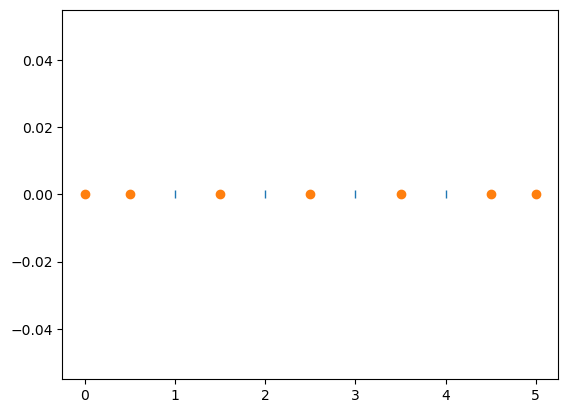

In [304]:
x_faces = np.linspace(0, L, n_cells_x + 1)
x_centroids = 0.5 * (x_faces[1:] + x_faces[:-1])
x_centroids = np.hstack([x_faces[0], x_centroids, x_faces[-1]])  # we're adding two centroids overlapping with the first and last faces to keep the values of boundary conditions and to calculate distances to introduce the boundary conditions later

# distances between cell centers
delta_x_w = x_centroids[1:-1] - x_centroids[:-2]
delta_x_e = x_centroids[2:] - x_centroids[1:-1]

# lengths of cells
Delta_x = x_faces[1:] - x_faces[:-1]

if plot == 'true':
    plt.plot(x_faces, np.zeros_like(x_faces), '|')
    plt.plot(x_centroids, np.zeros_like(x_centroids), 'o')
    plt.show()

matrix coefficients - internal cells

In [305]:
a_W = Gamma * A / delta_x_w  + rho * u * A * (x_faces[:-1] - x_centroids[0:-2]) / delta_x_w 
a_E = Gamma * A / delta_x_e - rho * u * A * (x_centroids[2:] - x_faces[1:]) / delta_x_e
S_C = S * A * Delta_x
S_P = np.zeros_like(S_C)
a_P = a_W + a_E + rho * u * A - rho * u * A - S_P

matrix coefficients - left / west boundary

In [306]:
if W_boundary_type == 1:
    S_C[0] += a_W[0] * phi_W
    a_W[0] = 0
    # a_W[0] is already included in the a_P
else:
    S_C[0] += dphi_dx_W * A
    a_P[0] -= a_W[0]
    a_W[0] = 0

matrix coefficients - right / east boundary

In [307]:
if E_boundary_type == 1:
    S_C[-1] += a_E[-1] * phi_E
    a_E[-1] = 0
    # a_E[-1] is already included in the a_P
else:
    S_C[-1] += dphi_dx_E * A
    a_P[-1] -= a_E[-1]
    a_E[-1] = 0

assembling matrices

In [308]:
A = np.zeros([n_cells_x, n_cells_x])
b = np.zeros(n_cells_x)

for i in range(n_cells_x):
    if i == 0:  # left / west boundary
        A[i, i] = a_P[i]
        A[i, i + 1] = -a_E[i]
    elif i == n_cells_x - 1:
        A[i, i] = a_P[i]
        A[i, i - 1] = -a_W[i]
    else:
        A[i, i] = a_P[i]
        A[i, i - 1] = -a_W[i]
        A[i, i + 1] = -a_E[i]
        
b = S_C

print(A, b)

[[ 0.0295 -0.0095  0.      0.      0.    ]
 [-0.0105  0.02   -0.0095  0.      0.    ]
 [ 0.     -0.0105  0.02   -0.0095  0.    ]
 [ 0.      0.     -0.0105  0.02   -0.0095]
 [ 0.      0.      0.     -0.0105  0.0305]] [2. 0. 0. 0. 4.]


solution

here the [procedure for linear systems solution from the numpy library](https://numpy.org/devdocs/reference/generated/numpy.linalg.solve.html) is used

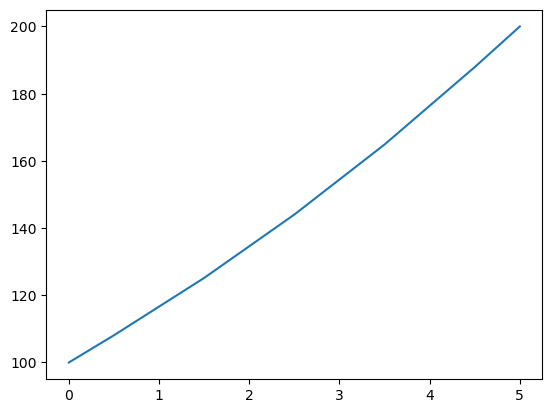

array([100.        , 108.10452972, 125.16669755, 144.02488305,
       164.86814071, 187.90542549, 200.        ])

In [309]:
phi = np.linalg.solve(A, b)

if W_boundary_type == 1:
    phi = np.hstack([phi_W, phi])
else:
    pass

if E_boundary_type == 1:
    phi = np.hstack([phi, phi_E])

if plot == 'true':
    plt.plot(x_centroids, phi)
    plt.show()

phi